## Imports

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

## Create log summaries

In [58]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Flatten a nested dictionary. Concatenate keys for nested elements.
    """
    items = []
    for k, v in d.items():
        new_key = f'{parent_key}{sep}{k}' if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif k == "new_representation":
            if v is None:
                items.append((new_key, "0 - 9"))
            elif "." in v:
                items.append((new_key, "'.', 'a' - 'i'"))
            elif "a" in v:
                items.append((new_key, "'a' - 'j'"))

            
        else:
            items.append((new_key, v))
    return dict(items)

def read_and_parse_tasks_log(path, save_to_csv=False):
    data = []

    if not os.path.isdir(path):
        print(f"The provided path {path} is not a directory.")
        return pd.DataFrame()

    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            log_file = os.path.join(item_path, 'all_tasks_log.json')
            if os.path.isfile(log_file):
                try:
                    with open(log_file, 'r') as file:
                        log_data = json.load(file)[0]  # Read only the first item
                        flattened_data = flatten_dict(log_data)
                        data.append(flattened_data)
                except Exception as e:
                    print(f"Error reading {log_file}: {e}")
    df = pd.DataFrame(data)
    if save_to_csv:
        df.to_csv(path+"/summary.csv", index=False)
        print("saved to "+path+"summary.csv")
    return df


In [60]:
path = "/work/jbriem/repos/master_thesis/results/baseline/arc_h_v"
data = read_and_parse_tasks_log(path, save_to_csv=True)
data.head(5)

saved to /work/jbriem/repos/master_thesis/results/baseline/arc_h_vsummary.csv


,date,model,usage_total_completion_tokens,usage_total_prompt_tokens,usage_total_cost,dataset,change_representation,new_representation,num_tasks,success_cnt,...,cat_success_cnt_fill_v,cat_success_cnt_move_v,cat_success_rate_pile_v,cat_success_rate_fill_h,cat_success_rate_pile_h,cat_success_rate_move_h,cat_success_rate_fill_v,cat_success_rate_move_v,solved_tasks,failure_log
0,2024-01-23_01-32-02,NousResearch/Llama-2-7b-chat-hf,118,502,None,arc,True,"'.', 'a' - 'i'",300,2,...,0,0,0.0,0.0,0.04,0.0,0.0,0.0,"[[arc_pile_h_0.json, 1.0], [arc_pile_h_43.json...",\n
1,2024-01-24_00-23-06,NousResearch/Llama-2-7b-chat-hf,151,612,None,arc,True,'a' - 'j',300,0,...,0,0,0.0,0.0,0.00,0.0,0.0,0.0,[],\n
2,2024-01-23_08-47-51,TheBloke/Llama-2-7B-GPTQ,118,502,None,arc,True,"'.', 'a' - 'i'",300,1,...,0,0,0.0,0.0,0.02,0.0,0.0,0.0,"[[arc_pile_h_0.json, 1.0]]",\n
3,2024-01-24_08-03-27,TheBloke/Llama-2-7B-GPTQ,151,612,None,arc,True,'a' - 'j',300,0,...,0,0,0.0,0.0,0.00,0.0,0.0,0.0,[],\n
4,2024-01-22_23-59-03,TheBloke/Llama-2-13B-chat-GPTQ,118,502,None,arc,True,"'.', 'a' - 'i'",300,0,...,0,0,0.0,0.0,0.00,0.0,0.0,0.0,[],\n


## Plotting functions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_performance_across_runs(dataframe, exp_column, score_column, task=""):
    # Filter the relevant columns
    df_filtered = dataframe[['model', exp_column, score_column]]

    # Convert Score to numeric values if they are in percentage format
    if df_filtered[score_column].dtype == object:
        df_filtered[score_column] = df_filtered[score_column].str.rstrip('%').astype('float') / 100.0

    # Identify the run with the highest overall score
    highest_score_run = df_filtered[df_filtered[score_column] == df_filtered[score_column].max()][exp_column].iloc[0]

    # Determine the sorting order based on the run's scores
    sort_order = df_filtered[df_filtered[exp_column] == highest_score_run].sort_values(by=score_column, ascending=False)['model']


    # Set the style for the plots
    plt.style.use('seaborn-darkgrid')

    # # Get unique models
    # models = df_filtered['model'].unique()

    # Create a line plot for each model
    for model in sort_order:
        model_data = df_filtered[df_filtered['model'] == model]
        plt.plot(model_data[exp_column], model_data[score_column], marker='o', label=model.split("/")[-1])
        
    # Adding legends, labels and title
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel(exp_column)
    plt.ylabel(score_column)
    if task != "":
        task += " - "
    plt.title(task + 'Performance of Models Across different Experiments')

    # Show the plot
    plt.show()


# Experiments

## Baseline - Naive

### 1D ARC

/tmp/ipykernel_1320817/1375631207.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


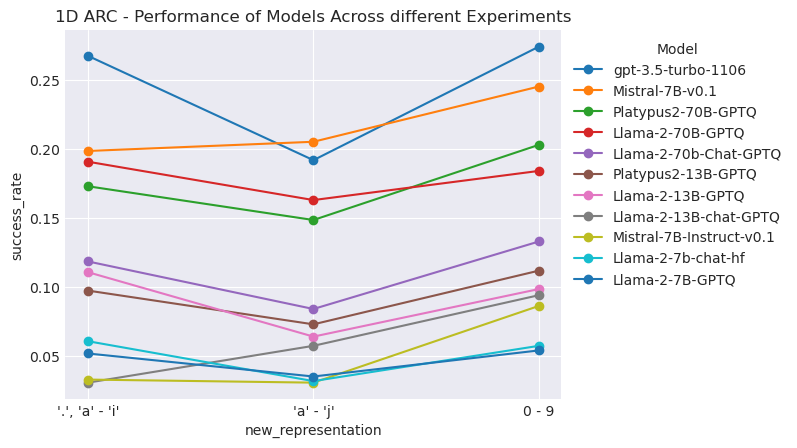

In [57]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline/arc_1D/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="1D ARC")

- Take best few models and compare categories?!
- take best few configurations, i.e. best model+repres -> means multiple times GPT 


### ARC H vs V

/tmp/ipykernel_1320817/1375631207.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


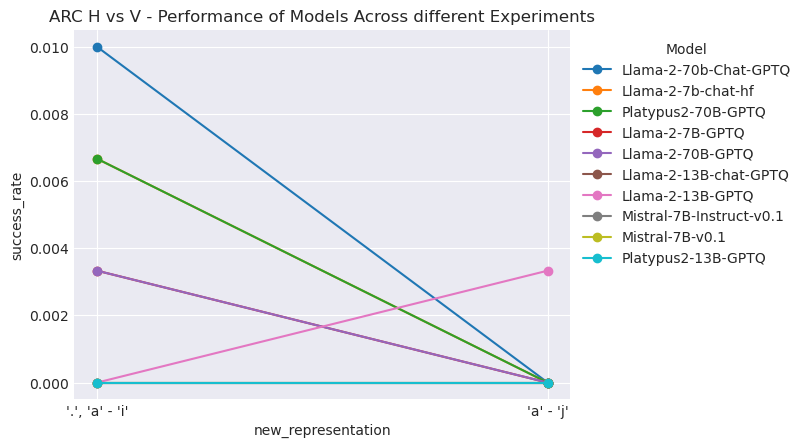

In [61]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline/arc_h_v/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="ARC H vs V")

### ARC original

In [ ]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline/arc/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="ARC 50 original tasks")